# Colab

In [1]:
# !git clone -b tree-ranking https://github.com/KernelA/education-recsys.git

In [2]:
# %cd /content/education-recsys/

In [3]:
# !pip install --no-cache-dir -r ./requirements.txt  kaggle

In [4]:
# %load_ext dotenv
# %dotenv

In [5]:
# !dvc repro dump_data

In [6]:
import os

In [7]:
is_colab = False

In [8]:
if is_colab:
    remote_dir = "/content/drive"
else:
    remote_dir = os.getcwd()

In [9]:
if is_colab:
    from google.colab import drive
    drive.mount(remote_dir)

In [10]:
if is_colab:
    out_exp_dir = os.path.join(remote_dir, "MyDrive/EducationRecSys/tree-ranking")
else:
    out_exp_dir = os.path.join(remote_dir, "catboost-dir")

In [11]:
if is_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

# Основной код

In [12]:
import os
from datetime import timedelta

import hydra
import seaborn as sns
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from implicit.als import AlternatingLeastSquares
from catboost import Pool, CatBoostClassifier, FeaturesData
import shap

In [13]:
sns.set_style("darkgrid")

In [14]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import compute_metrics
from recs_utils.load_data import MTSDataset
from recs_utils.split import TimeRangeSplit
from recs_utils.implicit_model import ImplicitRecommender
from recs_utils.ranking import convert_to_features_data

In [15]:
with hydra.initialize(config_path=os.path.join("configs", "data"), version_base="1.3"):
    config = hydra.compose("mts_lib")

In [16]:
df = pl.read_parquet(config.dump_files.interactions_path)
df_users = pl.read_parquet(config.dump_files.users_path)
df_items = MTSDataset.select_genres(pl.read_parquet(config.dump_files.items_path), 0.98)

In [17]:
df = df.filter(pl.col("item_id").is_in(df_items.select(pl.col("item_id").unique()).to_series()) & 
          pl.col("user_id").is_in(df_users.select(pl.col("user_id").unique()).to_series())
)

In [18]:
num_items = df.get_column("item_id").n_unique()

In [19]:
print("Num items:", num_items)

Num items: 59599


In [20]:
# max_items = 30_000
max_items = num_items

По причинам произвоидительности берём только элементы с наибольшим количеством оценок

In [21]:
if max_items != num_items:
    selected_item_ids = df.lazy().groupby("item_id").count().top_k(min(max_items, num_items),
                                                                   by="count").select(pl.col("item_id").unique()).collect().to_series()
    df = df.filter(pl.col("item_id").is_in(selected_item_ids))
    del selected_item_ids

Фильтрация случайных взаимодействий

In [22]:
df = MTSDataset.filter_noise_interactions(df)

In [23]:
len(df)

1116032

In [24]:
df.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01
63454,78434,87,NaN,2018-01-01
127451,14876,69,NaN,2018-01-01


In [25]:
df_users.head()

user_id,age,sex
u32,cat,cat
1,"""45_54""",null
2,"""18_24""","""0"""
3,"""65_inf""","""0"""
4,"""18_24""","""0"""
5,"""35_44""","""0"""


In [26]:
df_items.head(n=3)

item_id,title,genres,authors,year
u32,str,str,str,cat
128115,"""ворон-челобитч…","""зарубежная кла…","""Михаил Салтыко…","""1886"""
210979,"""скрипка ротшил…","""классическая п…","""Антон Чехов""","""1894"""
95632,"""испорченные де…","""зарубежная кла…","""Михаил Салтыко…","""1869"""


In [27]:
last_date = df.get_column("start_date").max()
folds = 1
start_date = last_date - timedelta(weeks=folds)
start_date, last_date

(datetime.date(2019, 12, 24), datetime.date(2019, 12, 31))

In [28]:
cv = TimeRangeSplit(start_date=start_date, folds=folds, interval=timedelta(weeks=1))
cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

(1, 1)

In [29]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
)
)

folds_info_with_stats = pl.from_dicts([info for _, _, info in folds_with_stats])

In [30]:
folds_info_with_stats

Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
date,date,i64,i64,i64,i64,i64,i64,i64
2019-12-24,2019-12-31,1103325,0,0,0,0,0,11150


In [31]:
del folds_info_with_stats

In [32]:
train_idx, test_idx, info = folds_with_stats[0]

In [33]:
global_train = df.join(train_idx, on=["user_id", "item_id"], how="inner")
global_test = df.join(test_idx, on=["user_id", "item_id"], how="inner")
global_train.shape, global_test.shape

((1103325, 5), (11150, 5))

In [34]:
n_samples = 50
top_N = 10

In [35]:
global_train.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01
63454,78434,87,NaN,2018-01-01
127451,14876,69,NaN,2018-01-01


In [36]:
mid_point = global_train.get_column("start_date").dt.timestamp("ms").quantile(0.6, interpolation="nearest")

In [37]:
train_first_stage = global_train.filter(pl.col("start_date").dt.timestamp("ms") <= mid_point)
test_first_stage = global_train.filter(pl.col("start_date").dt.timestamp("ms") > mid_point)
test_first_stage = test_first_stage.filter(
    pl.col("user_id").is_in(train_first_stage.get_column("user_id").unique())
    )

In [38]:
del mid_point

In [39]:
train_first_stage.shape, test_first_stage.shape

((662395, 5), (435806, 5))

In [40]:
train_first_stage.select(pl.col("user_id").n_unique(), pl.col("item_id").n_unique())

user_id,item_id
u32,u32
104378,59560


In [41]:
test_first_stage.select(pl.col("user_id").n_unique(), pl.col("item_id").n_unique())

user_id,item_id
u32,u32
97482,58753


## 1 Этап

In [42]:
first_stage_recommender = ImplicitRecommender(
    AlternatingLeastSquares(factors=64, iterations=10, random_state=1123),
)

In [43]:
first_stage_recommender.fit(train_first_stage, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
test_first_stage_pred = first_stage_recommender.recommend(test_first_stage, num_recs_per_user=n_samples)

In [45]:
compute_metrics(test_first_stage, test_first_stage_pred, top_N, with_separate_k_col=False)

name,value
str,f64
"""prec@1""",0.004811
"""recall@1""",0.004811
"""prec@2""",0.00477
"""recall@2""",0.00477
"""prec@3""",0.004551
"""recall@3""",0.004551
"""prec@4""",0.004375
"""recall@4""",0.004375
"""prec@5""",0.004245


In [46]:
candidates = test_first_stage_pred

In [47]:
selected_cols = ["user_id", "item_id", "rank", "target"]

In [48]:
catboost_pos_sampels = candidates.lazy().join(test_first_stage.lazy(
), on=["user_id", "item_id"]).with_columns(pl.lit(1, dtype=pl.Int8).alias("target")).select(selected_cols).collect()


In [49]:
catboost_pos_sampels.describe()

describe,user_id,item_id,rank,target
str,f64,f64,f64,f64
"""count""",12026.0,12026.0,12026.0,12026.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",78860.367786,161035.611176,21.252204,1.0
"""std""",46252.252205,93793.587103,14.556958,0.0
"""min""",21.0,137.0,1.0,1.0
"""max""",159574.0,321346.0,50.0,1.0
"""median""",76762.5,157379.5,19.0,1.0
"""25%""",39088.0,82385.0,8.0,1.0
"""75%""",119353.0,245087.0,33.0,1.0


In [50]:
catboost_neg_samples = candidates.lazy().join(catboost_pos_sampels.lazy(), how="anti", on=[
    "user_id", "item_id"]).with_columns(pl.lit(0, dtype=catboost_pos_sampels.schema["target"]).alias("target")).collect().sample(n=len(catboost_pos_sampels) * 2, seed=10, with_replacement=False)

In [51]:
catboost_neg_samples.describe()

describe,user_id,item_id,rank,target
str,f64,f64,f64,f64
"""count""",24052.0,24052.0,24052.0,24052.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",79829.570389,157878.716323,25.487319,0.0
"""std""",46006.709631,93063.722442,14.33189,0.0
"""min""",31.0,13.0,1.0,0.0
"""max""",159610.0,321575.0,50.0,0.0
"""median""",80116.0,155451.0,25.0,0.0
"""25%""",40108.0,78703.0,13.0,0.0
"""75%""",119644.0,238531.0,38.0,0.0


In [52]:
catboost_samples = catboost_pos_sampels.vstack(catboost_neg_samples)

In [53]:
del catboost_pos_sampels
del catboost_neg_samples

In [54]:
catboost_samples.head(n=3)

user_id,item_id,rank,target
u32,u32,u32,i8
21,11614,46,1
43,81342,2,1
43,10522,6,1


In [55]:
catboost_samples.select(pl.col("target").value_counts()).unnest("target").select(
    pl.col("target"),
    pl.col("counts") / pl.col("counts").sum()
)

target,counts
i8,f64
1,0.333333
0,0.666667


## 2 Этап

In [56]:
# df_users_features = df_users
df_users_features = df_users.with_columns(
    pl.col("age").cast(str).fill_null("unknown"),
    pl.col("sex").cast(str).fill_null("unknown")
)

In [57]:
# df_items_features = df_items.select(pl.all().exclude(["IMDb_URL", "title"])).with_columns(pl.col("release_date").dt.timestamp("us"))
df_items_features = df_items.select(
    pl.col("item_id"),
    pl.col("genres"),
    pl.col("year")
).with_columns(
    pl.col("genres").cast(str).fill_null("genre_unknown").alias("genres"),
    pl.col("year").cast(str).fill_null("unknown").alias("year")
)

In [58]:
catboost_samples = catboost_samples.lazy().join(df_users_features.lazy(
), on="user_id").join(df_items_features.lazy(), on="item_id").collect()


In [59]:
catboost_samples.describe()

describe,user_id,item_id,rank,target,age,sex,genres,year
str,f64,f64,f64,f64,str,str,str,str
"""count""",36078.0,36078.0,36078.0,36078.0,"""36078""","""36078""","""36078""","""36078"""
"""null_count""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""",79506.502855,158931.014607,24.075614,0.333333,null,null,null,null
"""std""",46090.326119,93318.212348,14.544776,0.471411,null,null,null,null
"""min""",21.0,13.0,1.0,0.0,"""18_24""","""0""","""английский язы…","""1822"""
"""max""",159610.0,321575.0,50.0,1.0,"""unknown""","""unknown""","""юмористическая…","""unknown"""
"""median""",79081.0,155451.0,23.0,0.0,null,null,null,null
"""25%""",39753.0,80195.0,11.0,0.0,null,null,null,null
"""75%""",119566.0,239503.0,37.0,1.0,null,null,null,null


In [60]:
catboost_samples.head(n=3)

user_id,item_id,rank,target,age,sex,genres,year
u32,u32,u32,i8,str,str,str,str
29432,174888,42,0,"""18_24""","""0""","""литература 19 …","""1836"""
75108,174888,41,0,"""18_24""","""0""","""литература 19 …","""1836"""
75463,174888,39,0,"""25_34""","""0""","""литература 19 …","""1836"""


In [61]:
catboost_train_users, catboost_test_users = train_test_split(catboost_samples.get_column("user_id").unique(), train_size=0.7, random_state=244) 

In [62]:
catboost_test_users, catboost_early_stpping_usesr = train_test_split(catboost_test_users, train_size=0.7, random_state=1212)

In [63]:
catboost_train = catboost_samples.filter(pl.col("user_id").is_in(catboost_train_users))
catboost_test = catboost_samples.filter(pl.col("user_id").is_in(catboost_test_users))
catboost_early_stopping = catboost_samples.filter(pl.col("user_id").is_in(catboost_early_stpping_usesr))

In [64]:
exclude_columns = ["item_id", "user_id", "target"]

In [65]:
target_train = catboost_train.get_column("target").to_numpy()
catboost_train = convert_to_features_data(catboost_train, exclude_columns)

In [66]:
target_test = catboost_test.get_column("target").to_numpy()
catboost_test = convert_to_features_data(catboost_test, exclude_columns)

In [67]:
target_early_stop = catboost_early_stopping.get_column("target").to_numpy()
catboost_early_stopping = convert_to_features_data(catboost_early_stopping, exclude_columns)

In [68]:
train_pool = Pool(
    data=catboost_train,
    label=target_train,
)

In [69]:
test_pool = Pool(
    data=catboost_test,
    label=target_test,
)

In [70]:
early_stop_pool = Pool(data=catboost_early_stopping, label=target_early_stop)

In [71]:
train_dir = os.path.join(out_exp_dir, "log")

In [72]:
os.makedirs(train_dir, exist_ok=True)

In [73]:
ranker = CatBoostClassifier(task_type='GPU', 
                            random_seed=3466, metric_period=50, 
                        eval_metric="AUC", 
                        custom_metric=["Recall", "Precision"],
                        iterations=2000,
                        train_dir=train_dir,
                        loss_function="Logloss"
                        )

In [74]:
model_path = os.path.join(out_exp_dir, "model", "model.cbm")

In [75]:
os.makedirs(os.path.dirname(model_path), exist_ok=True)

In [76]:
force_train = True

In [77]:
if os.path.exists(model_path) and not force_train:
    ranker.load_model(model_path)
else:
    ranker.fit(train_pool, eval_set=early_stop_pool)
    ranker.save_model(model_path)

Learning rate set to 0.040623
0:	test: 0.6717511	best: 0.6717511 (0)	total: 115ms	remaining: 3m 50s
50:	test: 0.7178597	best: 0.7178597 (50)	total: 4.85s	remaining: 3m 5s
100:	test: 0.7279524	best: 0.7279524 (100)	total: 9.96s	remaining: 3m 7s
150:	test: 0.7328340	best: 0.7328340 (150)	total: 14.4s	remaining: 2m 56s
200:	test: 0.7358582	best: 0.7358582 (200)	total: 18.9s	remaining: 2m 48s
250:	test: 0.7386163	best: 0.7386163 (250)	total: 23s	remaining: 2m 40s
300:	test: 0.7395789	best: 0.7395789 (300)	total: 27.3s	remaining: 2m 33s
350:	test: 0.7402876	best: 0.7402876 (350)	total: 31.8s	remaining: 2m 29s
400:	test: 0.7408410	best: 0.7408410 (400)	total: 36.1s	remaining: 2m 24s
450:	test: 0.7409101	best: 0.7409101 (450)	total: 40.3s	remaining: 2m 18s
500:	test: 0.7411829	best: 0.7411829 (500)	total: 44.8s	remaining: 2m 13s
550:	test: 0.7412103	best: 0.7412103 (550)	total: 49s	remaining: 2m 8s
600:	test: 0.7415898	best: 0.7415898 (600)	total: 53.2s	remaining: 2m 3s
650:	test: 0.7421098	b

In [78]:
del early_stop_pool

## SHAP values

In [79]:
explainer = shap.TreeExplainer(ranker)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


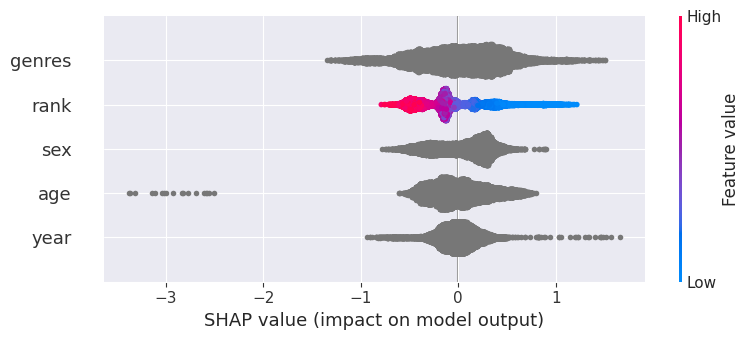

In [80]:
shap.summary_plot(explainer.shap_values(train_pool), features=np.hstack((catboost_train.num_feature_data,
                  catboost_train.cat_feature_data)), feature_names=catboost_train.get_feature_names())

In [81]:
del explainer

In [82]:
predicted_values = ranker.predict_proba(test_pool)[:, 1]
print("ROC AUC: ", roc_auc_score(test_pool.get_label(), predicted_values))
del predicted_values
del test_pool

ROC AUC:  0.7188970797269337


## Сравнение моделей

In [83]:
global_test = global_test.filter(pl.col("user_id").is_in(train_first_stage.get_column("user_id").unique()))

In [84]:
num_candidates = 200

In [85]:
first_stage_global_pred = first_stage_recommender.recommend(global_test, num_recs_per_user=num_candidates)

In [86]:
one_stage_model_metrics = compute_metrics(global_test, first_stage_global_pred, top_N, with_separate_k_col=True)

In [87]:
global_test_features = first_stage_global_pred.lazy().join(df_items_features.lazy(), on="item_id").join(df_users_features.lazy(), on="user_id").collect()

In [88]:
global_test_features.head(n=3)

user_id,item_id,rank,genres,year,age,sex
u32,u32,u32,str,str,str,str
16,36447,1,"""здоровое и пра…","""2015""","""45_54""","""0"""
16,209379,2,"""литература 20 …","""1910""","""45_54""","""0"""
16,89152,3,"""практическая п…","""2015""","""45_54""","""0"""


In [89]:
catboost_global_test = convert_to_features_data(global_test_features, exclude_columns)

In [90]:
predicted_proba = ranker.predict_proba(catboost_global_test)[:, 1]

In [91]:
del catboost_global_test

In [92]:
catboost_prediction = first_stage_global_pred.hstack(pl.DataFrame({"catboost_score": predicted_proba}, schema={"catboost_score": pl.Float32}))

In [93]:
catboost_prediction = catboost_prediction.sort(["user_id", "catboost_score"], descending=[False, True]).with_columns(
    pl.col("catboost_score").rank(method="ordinal", descending=True).over("user_id").alias("catboost_rank")
)

In [94]:
two_stage_model_metrics = compute_metrics(global_test, catboost_prediction.select(
    pl.col("user_id", "item_id"), pl.col("catboost_rank").alias("rank")), top_N, with_separate_k_col=True)


In [95]:
all_metrics = one_stage_model_metrics.with_columns(pl.lit("one_stage").alias("model")).vstack(
    two_stage_model_metrics.with_columns(pl.lit("two_stage").alias("model"))
)

In [96]:
all_metrics.head()

name,k,value,model
str,i64,f64,str
"""prec""",1,0.000381,"""one_stage"""
"""recall""",1,0.000381,"""one_stage"""
"""prec""",2,0.000508,"""one_stage"""
"""recall""",2,0.000508,"""one_stage"""
"""prec""",3,0.000338,"""one_stage"""


In [97]:
all_metrics.filter(pl.col("name").str.contains("prec"))

name,k,value,model
str,i64,f64,str
"""prec""",1,0.000381,"""one_stage"""
"""prec""",2,0.000508,"""one_stage"""
"""prec""",3,0.000338,"""one_stage"""
"""prec""",4,0.000349,"""one_stage"""
"""prec""",5,0.000355,"""one_stage"""
"""prec""",6,0.000317,"""one_stage"""
"""prec""",7,0.000417,"""one_stage"""
"""prec""",8,0.000412,"""one_stage"""
"""prec""",9,0.000395,"""one_stage"""


<Axes: xlabel='k', ylabel='value'>

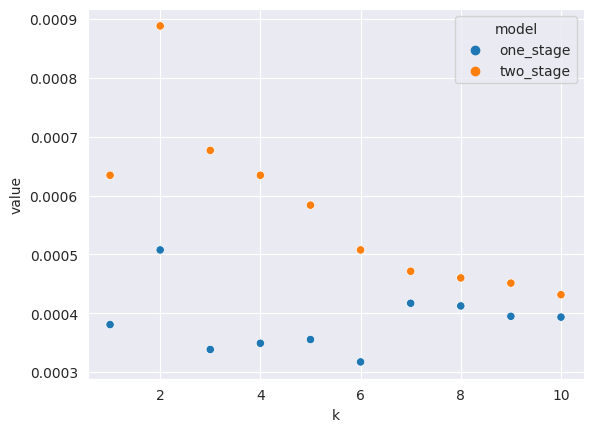

In [98]:
sns.scatterplot(all_metrics.filter(pl.col("name") == "prec"), x="k", y="value",  hue="model")

<Axes: xlabel='k', ylabel='value'>

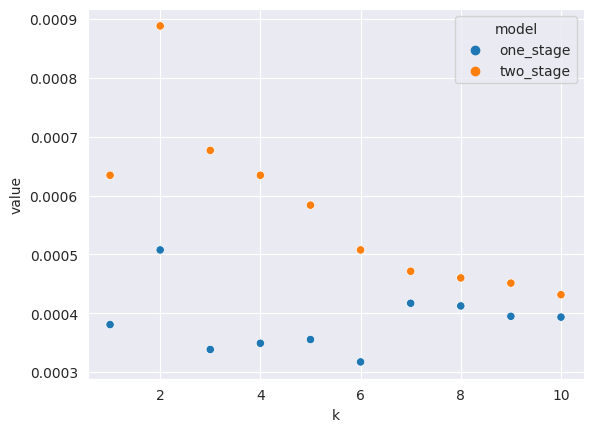

In [99]:
sns.scatterplot(all_metrics.filter(pl.col("name") == "recall"), x="k", y="value",  hue="model")

In [100]:
all_metrics.filter(pl.col("name").str.contains("MAP|MRR")).pivot(index="model", values="value", columns="name", aggregate_function="max")

model,MRR,MAP
str,f64,f64
"""one_stage""",0.0016,0.001367
"""two_stage""",0.00199,0.00155
